In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd /home/mabitbol/GBT-S140/analysis/

/home/mabitbol/GBT-S140/analysis


In [3]:
import foregrounds as fg
from scipy.optimize import curve_fit
import emcee
import corner

In [4]:
from __future__ import unicode_literals

figsize(10,8)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 24
rcParams['legend.borderaxespad'] = 1

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [5]:
freqs = np.array([408e6, 4.575e9, 5.625e9, 6.125e9, 28.5e9, 44.1e9, 70.3e9, 143e9, 217e9, 353e9, 545e9, 857e9])

In [6]:
s140flux = np.array([5.419, 2.132, 2.045, 1.947, 3.138, 3.015, 4.127, 24.915, 126.023, 572.549, 2049.176, 7049.524])
serrs = 0.2 * s140flux

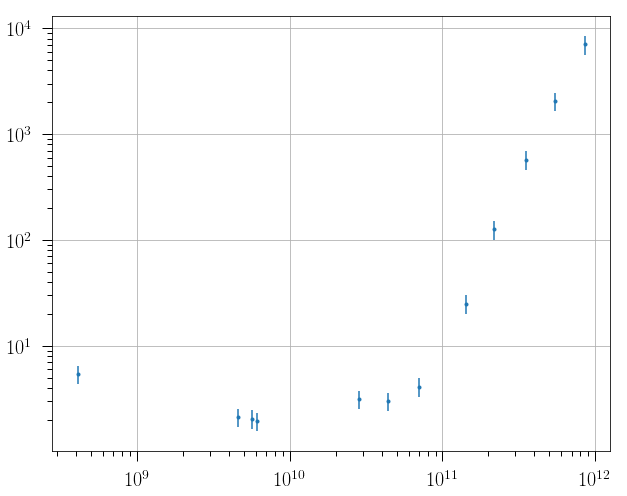

In [7]:
errorbar(freqs, s140flux, serrs, fmt='.')
yscale('log')
xscale('log')
grid()

In [8]:
beam = pi*(0.2*pi/180.)**2
beam2 = pi*((0.16/60.)*pi/180.)**2

In [9]:
def signal(freqs, EM, Asd, nup, Ad, Bd, Acmb, As):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000.)
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=18.96)
    amefit = fg.ame(freqs, Asd=Asd, nup=nup) 
    ccmb = fg.cmb(freqs, A=Acmb)
    synch = fg.synchrotron(freqs, As=As)
    return (fffit + dustfit + amefit + ccmb + synch) * beam

In [10]:
def signal2(freqs, EM1, EM2, Ad, Bd, abeam, Acmb, As):
    fffit = fg.freefreep(freqs, EM=EM1, Te=8000.) * beam
    fffit2 = fg.freefreep(freqs, EM=EM2, Te=8000.) * abeam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=18.96) * beam
    ccmb = fg.cmb(freqs, A=Acmb) * beam
    synch = fg.synchrotron(freqs, As=As) * beam
    return np.abs(fffit) + np.abs(fffit2) + np.abs(dustfit) + np.abs(ccmb) + np.abs(synch)

In [11]:
def signal3(freqs, EM, Ad, Bd, Acmb, As):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000.)
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=18.96)
    ccmb = fg.cmb(freqs, A=Acmb)
    synch = fg.synchrotron(freqs, As=As)
    return (fffit + dustfit + ccmb + synch) * beam

In [16]:
pn = np.array([5e3, 1.e-3, 20.e9, 1., 2., 30.e-6, 1e3])
bounds = ( [0, 0, 0, 0, 0, -1., 0], [1e4, 1., 1e11, 1., 3., 1., 1e6])
x = curve_fit(signal, freqs, s140flux, p0=pn, sigma=serrs, absolute_sigma=True, bounds=bounds)
pfit = x[0]

In [17]:
pn2 = np.array([5e3 , 1.e7, 0.1, 2., beam2, 30e-6, 1e3])
bounds2 = ( [0, 1.e5, 0, 0, 0, -1., 0], [1e4, 1.e9, 1., 3., 1., 1., 1e6])
x = curve_fit(signal2, freqs, s140flux, p0=pn2, sigma=serrs, absolute_sigma=True, bounds=bounds2)
pfit2 = x[0]

In [18]:
pn3 = np.array([5e3, 1., 2., 30.e-6, 1e3])
bounds3 = ( [0, 0, 0, -1., 0], [1e4, 1., 3., 1., 1e6])
x = curve_fit(signal3, freqs, s140flux, p0=pn3, sigma=serrs, absolute_sigma=True, bounds=bounds3)
pfit3 = x[0]

In [19]:
rchisq1 = np.sum( ( s140flux - signal(freqs, *pfit))**2 / serrs**2 ) / (len(freqs) - 7.)
rchisq2 = np.sum( ( s140flux - signal2(freqs, *pfit2))**2 / serrs**2 ) / (len(freqs) - 7.)
rchisq3 = np.sum( ( s140flux - signal3(freqs, *pfit3))**2 / serrs**2 ) / (len(freqs) - 5.)
print rchisq1, rchisq2, rchisq3

0.165053327788 1.29325009939 0.923744601635


In [20]:
print "EM, Asd, nup, Ad, Bd, Acmb, As"
print pfit

EM, Asd, nup, Ad, Bd, Acmb, As
[  4.60070813e+02   1.88889769e-03   3.23075308e+10   6.08829779e-03
   1.77217290e+00   1.53562008e-04   1.06913623e+03]


In [21]:
print "EM1, EM2, Ad, Bd, abeam, Acmb, As"
print pfit2

EM1, EM2, Ad, Bd, abeam, Acmb, As
[  5.31585742e+02   6.23129536e+05   6.04823201e-03   1.88389994e+00
   2.37069230e-14   3.75548563e-04   8.67290849e+02]


In [22]:
print "EM, Ad, Bd, Acmb, As"
print pfit3

EM, Ad, Bd, Acmb, As
[  5.31363745e+02   6.04820206e-03   1.88396344e+00   3.75735170e-04
   8.67812470e+02]


In [23]:
nu = np.linspace(freqs[0], freqs[-1], 1000)

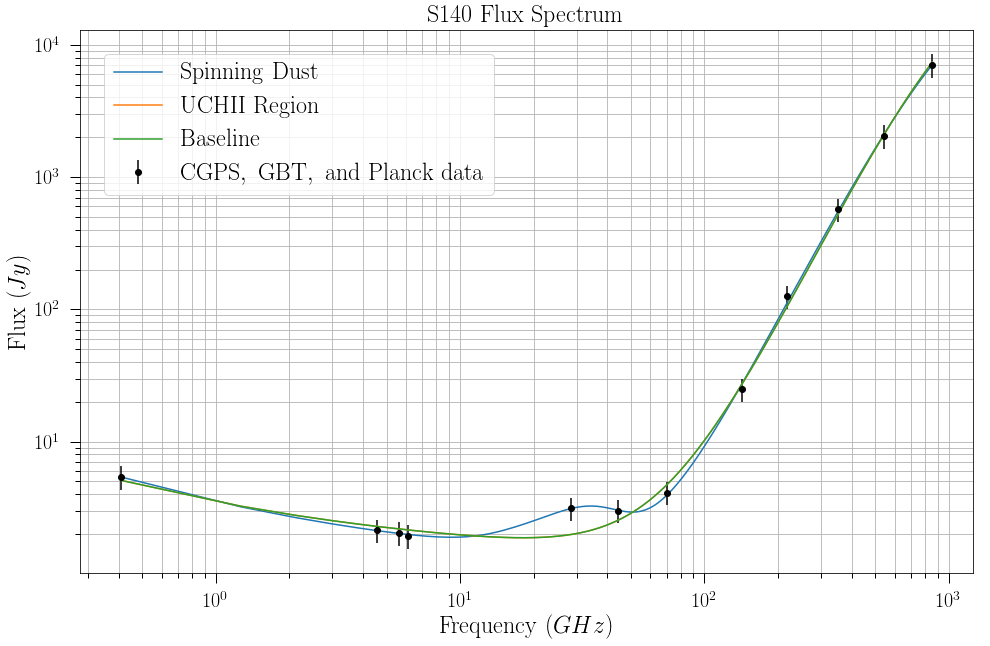

In [26]:
figure(figsize=(16,10))
plot(nu*1e-9, signal(nu, *pfit), label='$\mathrm{Spinning\ Dust}$')
plot(nu*1e-9, signal2(nu, *pfit2), label='$\mathrm{UCHII\ Region}$')
plot(nu*1e-9, signal3(nu, *pfit3), label='$\mathrm{Baseline}$')
errorbar(freqs*1e-9, s140flux, yerr=serrs, fmt='ko',label='$\mathrm{CGPS,\ GBT,\ and\ Planck\ data}$')

xscale('log')
yscale('log')
xlabel('$\mathrm{Frequency}\ (GHz)$')
ylabel('$\mathrm{Flux}\ (Jy)$')
legend(loc=2, ncol=1)
grid()
#ylim(1e-1, 1e5)
grid(which='minor')
title('$\mathrm{S140\ Flux\ Spectrum}$')
#savefig('../notebooks/fullspectrum_withspinningdust')